# Parametros Generales

In [290]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

# Parámetros del sistema
FS = 48000          # Hz
FC = 1000           # Hz
BITS_PER_SYMBOL = 3
SPS = 128         # Samples per symbol
BETA = 0.35
SPAN = 8            # Duración filtro RRC en símbolos

# Símbolos por segundo resultantes:
RS = FS // SPS      # = 48000/128 = 375 sps

# Generacion de bits

In [291]:


def ascii_to_bits(mensaje: str) -> np.ndarray:
    """
    Convierte una cadena ASCII en un vector de bits (0/1) de tipo int.
    1 caracter = 8 bits.
    """
    bin_str = ''.join(format(ord(c), '08b') for c in mensaje)
    bits = np.fromiter((int(b) for b in bin_str), dtype=np.int8)
    return bits

def bits_to_ascii(bits: np.ndarray) -> str:
    """
    Convierte un vector de bits (0/1) a cadena ASCII.
    La longitud de bits debe ser múltiplo de 8.
    """
    bits = bits.astype(int)
    bin_str = ''.join(str(b) for b in bits)
    chars = [chr(int(bin_str[i:i+8], 2)) for i in range(0, len(bin_str), 8)]
    return ''.join(chars)

def pad_bits_to_symbol_multiple(bits: np.ndarray, bits_per_symbol: int = 3):
    """
    Rellena con ceros al final para que la longitud de bits sea múltiplo
    de bits_per_symbol (3 para 8-PSK).
    Devuelve bits_padded, pad_bits (cuántos ceros se agregaron).
    """
    n = len(bits)
    r = n % bits_per_symbol
    if r == 0:
        return bits, 0
    pad = bits_per_symbol - r
    bits_padded = np.concatenate([bits, np.zeros(pad, dtype=np.int8)])
    return bits_padded, pad


# Bits a Simbolos 8psk

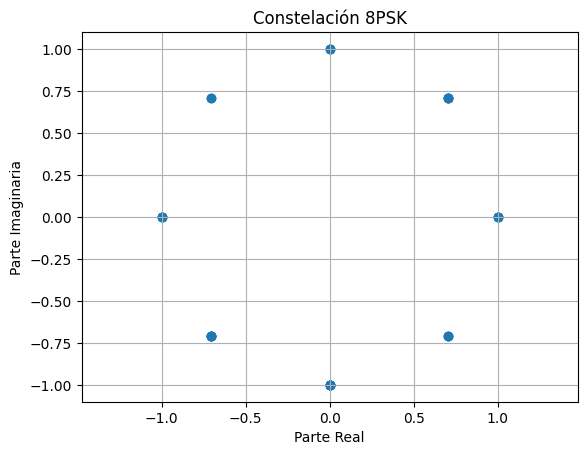

In [292]:
def bits_to_symbols_8psk(bits):
    """
    Mapea una secuencia de bits a símbolos 8PSK sobre el círculo unitario.
    Usa agrupación de 3 bits por símbolo con mapeo Gray sencillo.

    Parámetros:
        bits : ndarray de enteros (0/1), shape (N,)

    Retorna:
        symbols : ndarray complejo, shape (N_symbols,)
            Símbolos 8PSK en el círculo unitario.
    """
    # Asegurar que la longitud sea múltiplo de 3
    n_triples = len(bits) // 3
    bits = bits[:3 * n_triples]
    bits_reshaped = bits.reshape(-1, 3)

    # Convertir cada grupo de 3 bits a un índice 0..7
    indices = bits_reshaped[:, 0] * 4 + bits_reshaped[:, 1] * 2 + bits_reshaped[:, 2] * 1

    # Mapeo Gray opcional (puedes ajustar si quieres otro mapa)
    gray_map = np.array([0, 1, 3, 2, 6, 7, 5, 4])  # ejemplo
    gray_indices = gray_map[indices]

    # Fase para cada símbolo (8PSK → 8 fases uniformes)
    phases = 2 * np.pi * gray_indices / 8.0

    # Símbolos complejos en el círculo unitario
    symbols = np.exp(1j * phases)
    return symbols

bits = np.random.randint(0, 2, 100)  # 1000 bits aleatorios
# Ejemplo de uso
symbols = bits_to_symbols_8psk(bits)
# Graficar
plt.figure()
plt.scatter(np.real(symbols), np.imag(symbols))
plt.title("Constelación 8PSK")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginaria")
plt.axis('equal')
plt.grid()
plt.show()

# FIltro SRRC

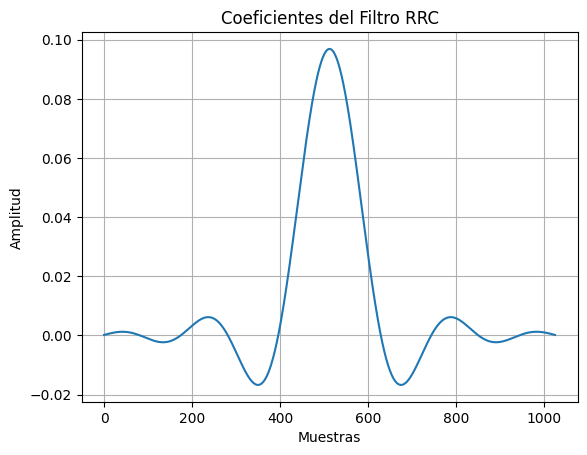

In [293]:
def rrc_filter(beta, span, sps):
    """
    Genera los coeficientes de un filtro Raised-Cosine Raíz (RRC/SRRC).

    Parámetros:
        beta : float
            Roll-off del filtro (0 < beta <= 1).
        span : int
            Duración del filtro en número de símbolos (ej: 6, 8, 10).
        sps : int
            Muestras por símbolo (Samples Per Symbol).

    Retorna:
        h : ndarray de floats, shape (span*sps + 1,)
            Coeficientes del filtro RRC.
    """
    N = span * sps
    t = np.arange(-N/2, N/2 + 1) / sps  # tiempo en unidades de T_símbolo

    h = np.zeros_like(t, dtype=float)
    for i, ti in enumerate(t):
        if np.isclose(ti, 0.0):
            h[i] = 1.0 - beta + (4 * beta / np.pi)
        elif np.isclose(abs(ti), 1/(4*beta)):
            # punto singular tratado aparte
            h[i] = (beta/np.sqrt(2)) * (
                ((1 + 2/np.pi) * np.sin(np.pi/(4*beta))) +
                ((1 - 2/np.pi) * np.cos(np.pi/(4*beta)))
            )
        else:
            num = np.sin(np.pi * ti * (1 - beta)) + \
                  4 * beta * ti * np.cos(np.pi * ti * (1 + beta))
            den = np.pi * ti * (1 - (4 * beta * ti)**2)
            h[i] = num / den

    # Normalizar energía (opcional pero recomendable)
    h = h / np.sqrt(np.sum(h**2))
    return h

# Ejemplo de uso
rrc_coeffs = rrc_filter(BETA, SPAN, SPS)
plt.figure()
plt.plot(rrc_coeffs)
plt.title("Coeficientes del Filtro RRC")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

# Agregar Ceros entre simbolos

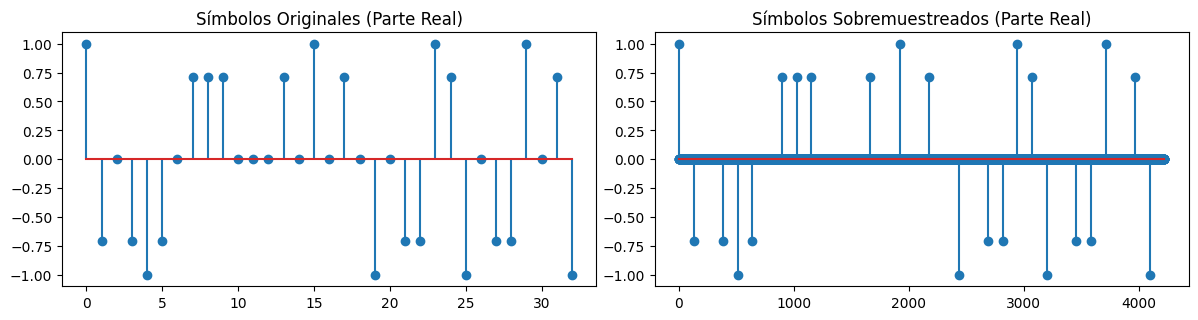

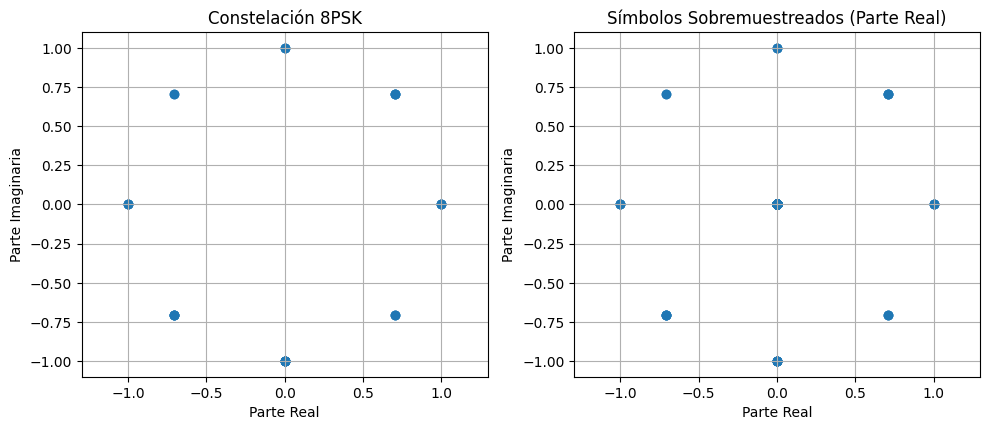

In [294]:
def upsample_symbols(symbols, sps):
    """
    Sobremuestrea los símbolos insertando (sps-1) ceros entre ellos.

    Parámetros:
        symbols : ndarray complejo, shape (N_symbols,)
        sps : int
            Muestras por símbolo.

    Retorna:
        x_upsampled : ndarray complejo, shape (N_symbols * sps,)
    """
    n = len(symbols)
    x_upsampled = np.zeros(n * sps, dtype=complex)
    x_upsampled[::sps] = symbols
    
    return x_upsampled
# Ejemplo de uso
x_upsampled = upsample_symbols(symbols, SPS)

# Graficar comparacion
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.stem(np.real(symbols))
plt.title("Símbolos Originales (Parte Real)")
plt.subplot(2, 2, 2)
plt.stem(np.real(x_upsampled))
plt.title("Símbolos Sobremuestreados (Parte Real)")
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
plt.scatter(np.real(symbols), np.imag(symbols))
plt.title("Constelación 8PSK")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginaria")
plt.axis('equal')
plt.grid()
plt.subplot(2,2,2)
plt.scatter(np.real(x_upsampled), np.imag(x_upsampled))
plt.title("Símbolos Sobremuestreados (Parte Real)")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginaria")
plt.axis('equal')
plt.grid()
plt.tight_layout()
plt.show()


# Conversor de bits a coseno levantado

In [295]:
def bits_to_rrc_waveform(bits, beta, span, sps):
    """
    Convierte bits → símbolos 8PSK → sobremuestreo → filtrado RRC,
    obteniendo la señal en banda base con pulso SRRC.

    Parámetros:
        bits : ndarray de enteros (0/1)
        beta : float
        span : int
        sps : int

    Retorna:
        tx_bb : ndarray complejo
            Señal en banda base (I + jQ) filtrada con RRC.
        rrc_taps : ndarray float
            Coeficientes del filtro RRC usado.
        symbols : ndarray complejo
            Símbolos 8PSK antes del filtrado (para depuración).
    """
    # 1) bits → símbolos 8PSK
    symbols = bits_to_symbols_8psk(bits)

    # 2) diseñar filtro RRC
    rrc_taps = rrc_filter(beta, span, sps)

    # 3) sobremuestrear símbolos
    x_up = upsample_symbols(symbols, sps)

    # 4) filtrar (pulso con coseno levantado)
    tx_bb = np.convolve(x_up, rrc_taps, mode='full')

    return tx_bb, rrc_taps, symbols



# Ejemplo de uso 

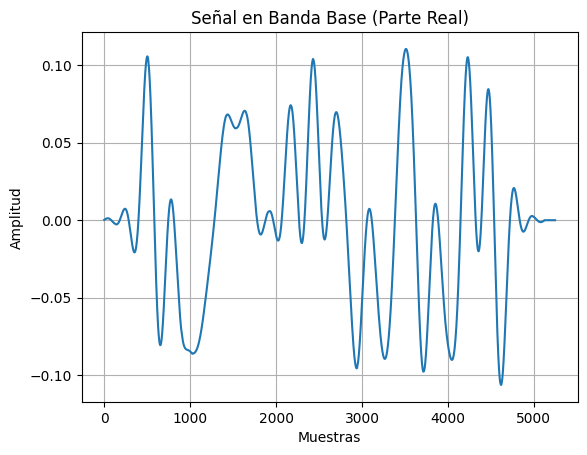

In [296]:
# 1. Generar bits
bits = bits
# 2. Obtener señal en banda base SRRC
tx_bb, rrc_taps, symbols = bits_to_rrc_waveform(bits, BETA, SPAN, SPS)

# tx_bb es tu señal “coseno levantado” en banda base (compleja)
# Luego podrás llevarla a banda pasante (audio) con una portadora cos/sin
# Graficar o guardar tx_bb según necesites
plt.figure()
plt.plot(np.real(tx_bb))
plt.title("Señal en Banda Base (Parte Real)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

# Generar Portadora

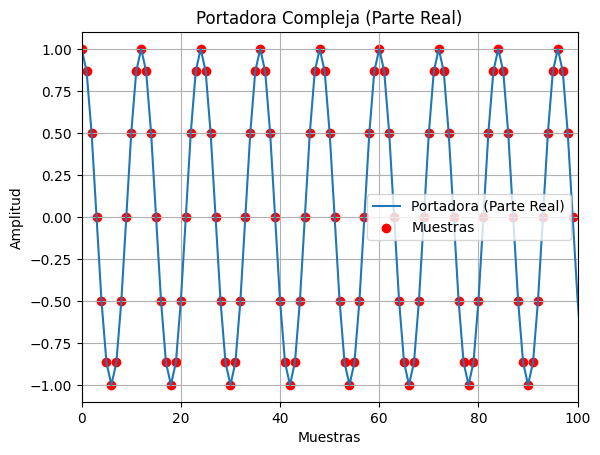

In [297]:
def generate_carrier(fc, fs, n_samples):
    """
    Genera una portadora compleja e^{j2πf_c t}.

    Parámetros:
        fc : float
            Frecuencia de la portadora en Hz.
        fs : float
            Frecuencia de muestreo.
        n_samples : int
            Número de muestras a generar.

    Retorna:
        carrier : ndarray complejo de shape (n_samples,)
    """
    t = np.arange(n_samples) / fs
    carrier = np.exp(1j * 2 * np.pi * fc * t)
    return carrier
# Ejemplo de uso
fc = 4000  # frecuencia de la portadora en Hz

carrier = generate_carrier(fc, FS, len(tx_bb))
# Graficar la portadora
plt.figure()
plt.plot(np.real(carrier), label='Portadora (Parte Real)')
plt.scatter(np.arange(0, 100), np.real(carrier[:100]), color='red', label='Muestras')
plt.xlim(0, 100)
plt.title("Portadora Compleja (Parte Real)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend()
plt.grid()
plt.show()


# Funcion Moduladora

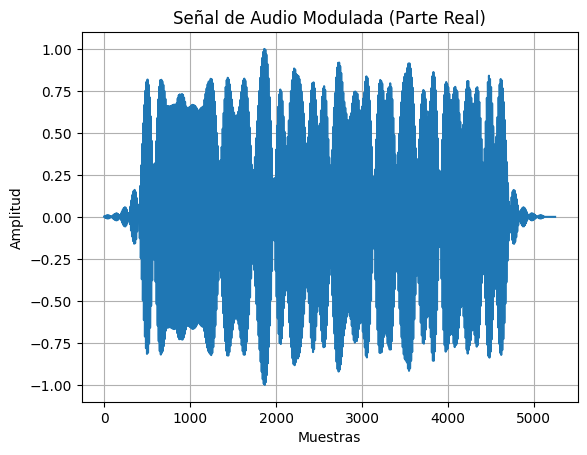

In [298]:
def modulate_to_passband(tx_bb, fc, fs):
    """
    Modula una señal de banda base (compleja) hacia banda pasante real para audio.

    Parámetros:
        tx_bb : ndarray complejo
            Señal en banda base (SRRC) I+jQ.
        fc : float
            Frecuencia de portadora en Hz.
        fs : float
            Frecuencia de muestreo en Hz.

    Retorna:
        tx_audio : ndarray float
            Señal real modulada lista para reproducir como audio.
    """
    n_samples = len(tx_bb)
    carrier = generate_carrier(fc, fs, n_samples)
    
    # Multiplicación complejo × complejo → señal analógica compleja
    tx_passband_complex = tx_bb * carrier
    
    # Sacar parte real → audio físico
    tx_audio = np.real(tx_passband_complex)

    # Normalizar para evitar clipping
    tx_audio /= np.max(np.abs(tx_audio) + 1e-12)

    return tx_audio
# Ejemplo de uso
tx_audio = modulate_to_passband(tx_bb, fc, FS)
# Graficar la señal de audio modulada
plt.figure()
plt.plot(tx_audio)
plt.title("Señal de Audio Modulada (Parte Real)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

# Generar audio

In [299]:

def play_audio(signal, fs):
    """
    Muestra un reproductor de audio para la señal dada.

    Parámetros:
        signal : ndarray float
        fs : int
            Frecuencia de muestreo.
    """
    return Audio(signal.astype(np.float32), rate=fs)


# Secuencia Piloto

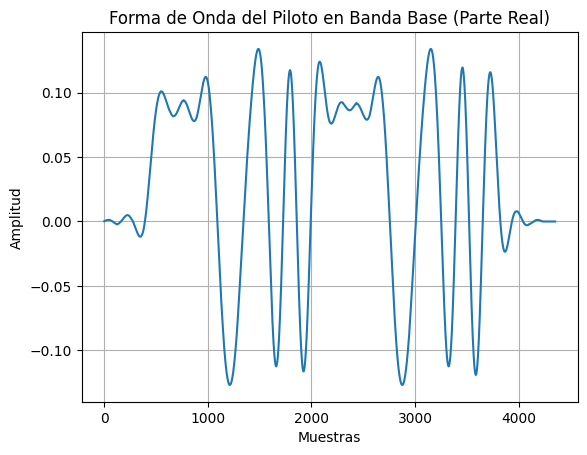

In [ ]:
import numpy as np

# Barker 13 en ±1
BARKER13 = np.array([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1], dtype=float)

def generate_pilot_symbols(repeticiones=10):
    """
    Devuelve los símbolos complejos BPSK de la secuencia Barker 13.
    """
    return np.tile(BARKER13, repeticiones).astype(complex)

def pilot_rrc_waveform(rrc_taps, sps):
    """
    Genera la forma de onda del piloto en banda base (ya filtrado con SRRC)
    usando los mismos 'rrc_taps' y 'sps' que el payload.
    """
    pilot_syms = generate_pilot_symbols()              # (N_pilot,)
    # upsample
    x_up = np.zeros(len(pilot_syms) * sps, dtype=complex)
    x_up[::sps] = pilot_syms
    # filtrar con el mismo SRRC
    pilot_bb = np.convolve(x_up, rrc_taps, mode='full')
    return pilot_bb
# Ejemplo de uso
pilot_bb = pilot_rrc_waveform(rrc_taps, SPS)
plt.figure()
plt.plot(np.real(pilot_bb))
plt.title("Forma de Onda del Piloto en Banda Base (Parte Real)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

# Creacion del payload

In [301]:
def build_payload_bits(mensaje: str,
                       bits_per_symbol: int = 3,
                       header_bits: int = 16):
    """
    Construye el payload lógico:
      - Convierte texto ASCII a bits
      - Agrega un header con la longitud en bytes (16 bits)
      - Hace padding para múltiplo de bits_per_symbol
    Devuelve:
      bits_payload_padded : np.ndarray de 0/1 listo para mapear a símbolos
      meta : dict con info útil para el receptor
    """
    # 1) Texto → bits (mensaje)
    bits_msg = ascii_to_bits(mensaje)
    n_bytes = len(mensaje)

    # 2) Header: longitud del mensaje en bytes (16 bits)
    if n_bytes >= 2**header_bits:
        raise ValueError("Mensaje demasiado largo para header de 16 bits.")
    header_str = format(n_bytes, f'0{header_bits}b')
    header_bits_vec = np.fromiter((int(b) for b in header_str), dtype=np.int8)

    # 3) Concatenar header + mensaje
    bits_payload = np.concatenate([header_bits_vec, bits_msg])

    # 4) Padding para múltiplo de bits_per_symbol
    bits_padded, pad_bits = pad_bits_to_symbol_multiple(bits_payload,
                                                       bits_per_symbol=bits_per_symbol)

    meta = {
        "n_bytes": n_bytes,
        "header_bits": header_bits,
        "bits_per_symbol": bits_per_symbol,
        "total_bits_no_pad": len(bits_payload),
        "total_bits_with_pad": len(bits_padded),
        "pad_bits": pad_bits,
    }

    return bits_padded, meta

def build_frame_from_text(mensaje: str,
                          fs: int,
                          sps: int,
                          beta: float,
                          span: int,
                          bits_per_symbol: int = 3,
                          guard_ms: float = 5.0,
                          pre_silence_ms: float = 200.0,
                          post_silence_ms: float = 200.0):
    """
    Construye la señal COMPLETA en banda base (frame) a partir de un mensaje de texto:
      - Texto → bits (con header y padding)
      - Bits → banda base SRRC (payload)
      - Genera piloto SRRC
      - Añade intervalo de guarda entre piloto y payload
      - Añade silencios inicial y final (en banda base)
    Devuelve:
      tx_bb_frame : np.ndarray complejo, banda base completa lista para modulación
      pilot_bb    : np.ndarray complejo, piloto SRRC (para correlación en el RX)
      meta        : dict con parámetros útiles (para el RX)
    """

    # 1) Construir payload lógico (texto → bits + header + padding)
    bits_payload, meta_payload = build_payload_bits(
        mensaje,
        bits_per_symbol=bits_per_symbol,
        header_bits=16
    )

    # 2) Payload en banda base SRRC
    tx_bb_payload, rrc_taps, symbols = bits_to_rrc_waveform(
        bits_payload, beta, span, sps
    )

    # 3) Piloto en banda base con el MISMO SRRC
    pilot_bb = pilot_rrc_waveform(rrc_taps, sps)

    # 4) Intervalo de guarda entre piloto y payload
    guard_samples = int((guard_ms / 1000.0) * fs)
    guard = np.zeros(guard_samples, dtype=complex)

    # 5) Silencios inicial y final (opcional pero MUY útil)
    pre_silence_samples = int((pre_silence_ms / 1000.0) * fs)
    post_silence_samples = int((post_silence_ms / 1000.0) * fs)

    pre_silence = np.zeros(pre_silence_samples, dtype=complex)
    post_silence = np.zeros(post_silence_samples, dtype=complex)

    # 6) Frame completo en banda base
    tx_bb_frame = np.concatenate([
        pre_silence,
        pilot_bb,
        guard,
        tx_bb_payload,
        post_silence
    ])

    # 7) Meta para el receptor
    meta = {
        "payload": meta_payload,
        "rrc_taps": rrc_taps,
        "symbols": symbols,
        "guard_ms": guard_ms,
        "pre_silence_ms": pre_silence_ms,
        "post_silence_ms": post_silence_ms,
        "len_pilot": len(pilot_bb),
        "len_guard": len(guard),
        "len_payload_bb": len(tx_bb_payload),
        "len_frame_bb": len(tx_bb_frame),
        "fs": fs,
        "sps": sps,
        "beta": beta,
        "span": span,
    }

    return tx_bb_frame, pilot_bb, meta


# Uso

mensaje enviado: Va4joOJVyMQJpBFvp JGUyxtbizh.nfRmutQgyXH.hahNvD,pW506Vdg ta917Hc.O2w16!5 wOOknBi1AQ9CxkCdYwDrOrxkx2850e,NQbbXdWuVDV2atZAHQhlJxNudV,c4AVDT jHjPI wYvgVY91hy.E5Oz8BKzfaxoEZs,hj5itvzipuxiSJA4lHLUE I588s.hnBDOmZmjQYVi4PTg8yNw.ybBZmsG,GOvbyfslWzZyuDU,T4RmP7JGDCC?sPNTA4UzJcJPHMGu0u2QLbCeWXihxTrxYth7E7L4yhuZzftSQE?Vmr fTNGWIcjfIL3RON?g7pZ xuHzqxzyhhD29upXqt!mWXSBvEFca6sL8NaozV irBGe1dNK6 k8Y1Lh5uQ?bCTlq2Kn?11gfraqkkcmNZI,?tfGe2ID4p7vrA41K0S4S5hc4,pwJkDQ6B2TXA9PkkgWWYKk42.q!,WLy3HGCgbSTthbEML,nPRV.oI5QoR


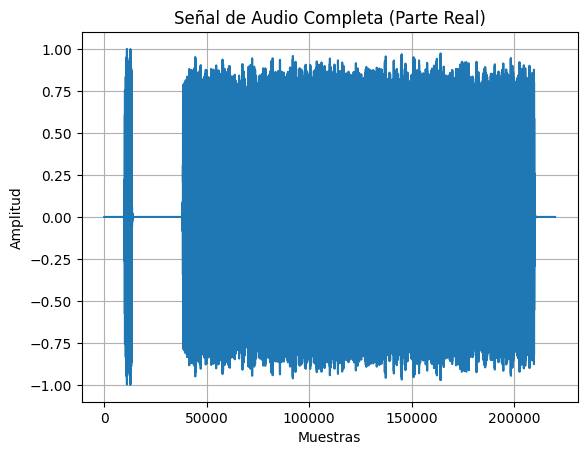

In [302]:
# Mensaje aleatorio de 500 caracteres
mensaje = ''.join(np.random.choice(
    list("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789 .,!?"),
    size=500
))
#mensaje = "Hola, este es un mensaje de prueba para la transmisión utilizando 8-PSK y pulso Raised-Cosine Raíz."
print(f"mensaje enviado: {mensaje}")

tx_bb_frame, pilot_bb, meta = build_frame_from_text(
    mensaje,
    fs=FS,
    sps=SPS,
    beta=BETA,
    span=SPAN,
    bits_per_symbol=BITS_PER_SYMBOL,  # =3 para 8PSK
    guard_ms=500.0,
    pre_silence_ms=200.0,
    post_silence_ms=200.0
)

fc = 4000  # tu portadora
tx_audio = modulate_to_passband(tx_bb_frame, fc, FS)


# Graficar la señal de audio completa
plt.figure()
plt.plot(tx_audio)
plt.title("Señal de Audio Completa (Parte Real)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

play_audio(tx_audio, FS)
